# Adding non-stationarity

In this notebook we add non-stationarity into the nursery dataset.

Here we follow the setting in [1] and just invert the class labels at a specified time point, simulating concept shift.

[1] Context Attentive Bandits: Contextual Bandit with Restricted Context https://arxiv.org/pdf/1705.03821.pdf


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
from src import evaluation
from src import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 4)

In [15]:
all_contexts

array([[1, 1, 1, 2],
       [1, 1, 1, 3],
       [1, 1, 1, 1],
       ...,
       [4, 3, 2, 2],
       [4, 3, 2, 3],
       [4, 3, 2, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
np.sum(np.where(y == 3, 1, 0))

328

In [18]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [19]:
all_rewards

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [20]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320,    2,  328, 4266, 4044])

### Fixed costs

In [21]:
costs_vector = np.zeros(all_contexts.shape)
for i in range(all_contexts.shape[0]):
    costs_vector[i, :] = np.array([0.01]*all_contexts.shape[1])

costs_vector.shape

(12960, 4)

In [22]:
costs_vector

array([[0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01]])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [23]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((5, all_contexts.shape[1]))
for n_arm in range(5):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ 5.95789122e-07 -1.09000277e-07  2.93197482e-07 -1.18003215e+01]]
1
[[-1.00673576e+00 -9.19997155e-01 -6.74921681e-01 -1.50037436e-06]]
2
[[-5.22142965e-01 -1.02495418e+00 -7.08156021e-01 -3.36494980e-06]]
3
[[-0.12732127 -0.22547861 -0.18243135  1.08588374]]
4
[[0.23537151 0.42056171 0.33544766 1.71326315]]


In [24]:
np.mean(coefs, axis= 0)

array([-0.28416558, -0.34997367, -0.24601222, -1.80023589])

## Algorithm evaluation

In [25]:
NUM_OF_TRIALS = all_contexts.shape[0]

In [26]:
NUM_REPETITIONS = 1

In [27]:
BETA = 1

In [28]:
np.random.seed(42)

In [29]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 2652.0
	Total reward: 2652.0
	Total cost: 0
Execution time: 0.2s
Average gain: 2652.0


In [30]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=all_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4282.0
	Total reward: 4282.0
	Total cost: 0
Execution time: 0.2s
Average gain: 4282.0


In [31]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=all_rewards.shape[1],
            alpha=0.45,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.2s
Average gain: 6645.0


In [32]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.45,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.45)
Beta = 1
Total gain: 9046.599999999522
	Total reward: 9565.0
	Total cost: 518.4000000001084
Execution time: 2.7s
Average gain: 9046.599999999522


In [33]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.1,
        omega=500,
        delta=0.15,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Beta = 1
Total gain: 8712.59999999989
	Total reward: 9231.0
	Total cost: 518.4000000001084
Execution time: 7.6s
Average gain: 8712.59999999989


In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=all_contexts, 
        number_of_actions=all_rewards.shape[1],
        max_no_red_context=all_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            all_contexts[:NUM_OF_TRIALS],
            all_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.002214193344116211 seconds
Trial 0, time 2022-05-04 12:41:18.640274
Trial 500, time 2022-05-04 12:41:22.309206
Trial 1000, time 2022-05-04 12:41:22.546501
Trial 1500, time 2022-05-04 12:41:23.007311
Trial 2000, time 2022-05-04 12:41:23.100139
Trial 2500, time 2022-05-04 12:41:23.261269
Trial 3000, time 2022-05-04 12:41:23.845472
Trial 3500, time 2022-05-04 12:41:24.366750
Trial 4000, time 2022-05-04 12:41:24.469641
Trial 4500, time 2022-05-04 12:41:24.585796
Trial 5000, time 2022-05-04 12:41:24.680774
Trial 5500, time 2022-05-04 12:41:25.826093
Trial 6000, time 2022-05-04 12:41:27.446371
Trial 6500, time 2022-05-04 12:41:27.767880
Trial 7000, time 2022-05-04 12:41:27.947593
Trial 7500, time 2022-05-04 12:41:28.212445
Trial 8000, time 2022-05-04 12:41:28.455058
Trial 8500, time 2022-05-04 12:41:28.626695
Trial 9000, time 2022-05-04 12:41:28.788115
Trial 9500, time 2022-05-04 12:41:28.895449
Trial 10000, time 2022-05-04 12:41:29.075367
Trial 10500, time 2022-05-04 12:41:29.178094


In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=all_contexts, 
        number_of_actions=all_rewards.shape[1],
        max_no_red_context=all_contexts.shape[1],
        beta=BETA,
        delta=0.1,
        window_length=1000,
        feature_flag=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            all_contexts[:NUM_OF_TRIALS],
            all_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.005007028579711914 seconds
Round 0, time 2022-05-04 12:41:29.930212
Round 500, time 2022-05-04 12:42:14.630049
Round 1000, time 2022-05-04 12:43:17.921872
Round 1500, time 2022-05-04 12:44:25.109407
Round 2000, time 2022-05-04 12:45:28.031287
Round 2500, time 2022-05-04 12:46:32.281425
Round 3000, time 2022-05-04 12:47:37.592635
Round 3500, time 2022-05-04 12:48:38.350664
Round 4000, time 2022-05-04 12:49:35.887484
Round 4500, time 2022-05-04 12:50:34.808116
Round 5000, time 2022-05-04 12:51:33.854220
Round 5500, time 2022-05-04 12:52:31.115142
Round 6000, time 2022-05-04 12:53:33.092838
Round 6500, time 2022-05-04 12:54:32.127048
Round 7000, time 2022-05-04 12:55:30.639811
Round 7500, time 2022-05-04 12:56:28.658836
Round 8000, time 2022-05-04 12:57:29.781290
Round 8500, time 2022-05-04 12:58:25.939817
Round 9000, time 2022-05-04 12:59:20.478323
Round 9500, time 2022-05-04 13:00:15.770783
Round 10000, time 2022-05-04 13:01:11.800619
Round 10500, time 2022-05-04 13:02:07.023479


In [36]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [37]:
(gain_egreedy / gain_random).shape

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_93349/834796977.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (gain_egreedy / gain_random).shape
/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_93349/834796977.py:1: RuntimeWarning: invalid value encountered in true_divide
  (gain_egreedy / gain_random).shape


(12960,)

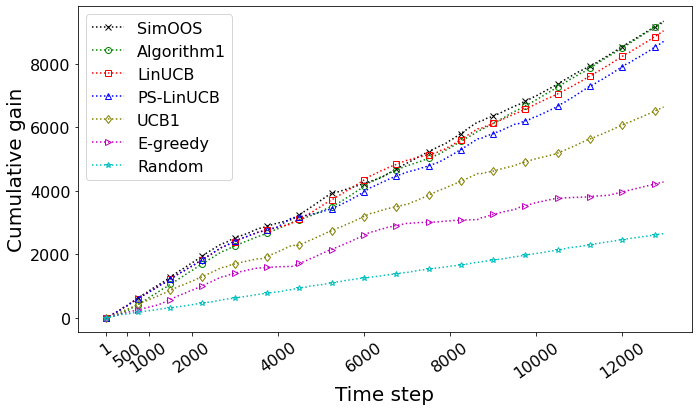

In [38]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


# Adding non-stationarity


### Non-stationarity in rewards

In [39]:
all_rewards.shape[0]

12960

In [40]:
# inverted_regions = [
#     slice(2000, 5000),
#     slice(10000, 11000),
# ]

In [41]:
inverted_regions = [
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 5000),
    slice(5000, 8000),
    slice(9000, 11000),
    slice(11000, 12960),
]

In [42]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, 12960),
]

In [43]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([3.33333333e-01, 1.54320988e-04, 2.53086420e-02, 3.29166667e-01,
       3.12037037e-01])

In [44]:
arm_from_to = [
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 1,
        1: 0,
    },
    {
        0: 2,
        2: 0,
        1: 3,
        3: 1
    },
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 3,
        3: 0,
        1: 2,
        2: 1,
    },
    {
        0: 2,
        2: 0,
        1: 3,
        3: 1
    },
]

In [45]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

for i, region in enumerate(inverted_regions):
    for arm_from in arm_from_to[i]:
        arm_to = arm_from_to[i][arm_from]
        
        new_rewards[region, arm_to] = all_rewards[region, arm_from]
        

In [46]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [47]:
new_contexts.shape, new_rewards.shape

((12960, 4), (12960, 5))

### Non-stationarity in costs

In [48]:
cost_change_points = [3000, 5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [49]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.1, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [50]:
interval_means

[array([0.03557982, 0.0761165 , 0.0655753 , 0.06838783]),
 array([0.07786263, 0.09356456, 0.0929258 , 0.06708128]),
 array([0.04411324, 0.04096267, 0.06349535, 0.03583055]),
 array([0.05571843, 0.05608712, 0.0531591 , 0.05885996]),
 array([0.09386102, 0.05720375, 0.03561521, 0.08708142]),
 array([0.08215075, 0.08994653, 0.07057343, 0.02652716])]

In [51]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [52]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

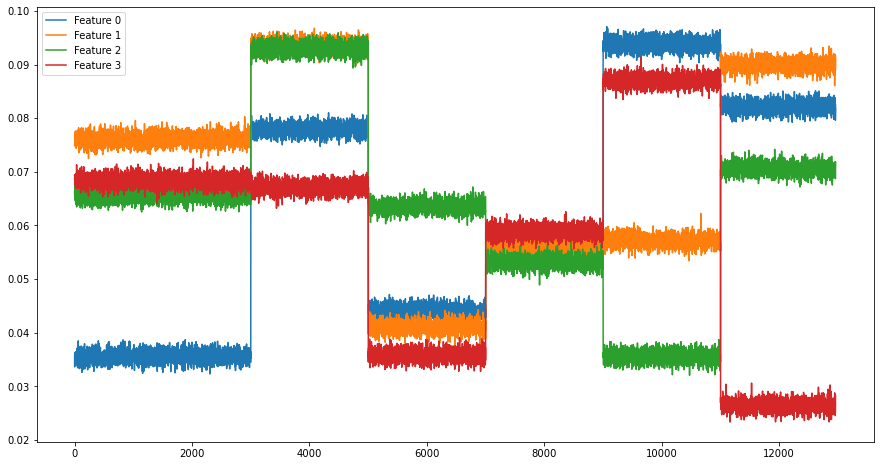

In [53]:
plot_costs(get_costs(), new_contexts.shape[0])

In [54]:
costs_obj = get_costs()

In [55]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [56]:
costs_vector.shape

(12960, 4)

## Plot expected reward minus sum of costs

Min expected gain for arm 1: -0.3404042374753636
Min expected gain for arm 2: -0.33000933643486197
Min expected gain for arm 3: -0.282009336434862
Min expected gain for arm 4: -0.2802855182348515
Min expected gain for arm 5: -0.3365068444455642


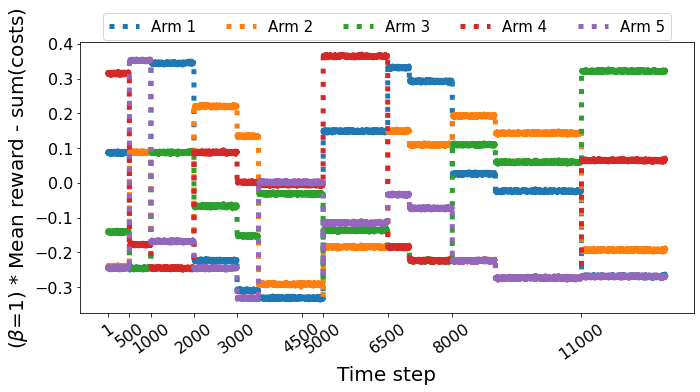

In [57]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 500, 1000, 2000, 3000, 4500, 5000, 6500, 8000, 11000]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Testing on non-stationary data

In [58]:
np.random.seed(42)

In [59]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 2566.0
	Total reward: 2566.0
	Total cost: 0
Execution time: 0.1s
Average gain: 2566.0


In [60]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 2935.0
	Total reward: 2935.0
	Total cost: 0
Execution time: 0.1s
Average gain: 2935.0


In [61]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.45,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 5954.0
	Total reward: 5954.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5954.0


In [62]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 615.5886276783494
	Total reward: 3907.0
	Total cost: 3291.411372321654
Execution time: 1.2s
Average gain: 615.5886276783494


In [63]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.03,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5172.588627678363
	Total reward: 8464.0
	Total cost: 3291.411372321654
Execution time: 1.3s
Average gain: 5172.588627678363


In [64]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0016207695007324219 seconds
Trial 0, time 2022-05-04 13:06:53.596580
Trial 500, time 2022-05-04 13:06:56.373285
Trial 1000, time 2022-05-04 13:06:58.096942
Trial 1500, time 2022-05-04 13:06:59.164707
Trial 2000, time 2022-05-04 13:07:01.287281
Trial 2500, time 2022-05-04 13:07:01.409315
Trial 3000, time 2022-05-04 13:07:01.535968
Trial 3500, time 2022-05-04 13:07:01.603966
Trial 4000, time 2022-05-04 13:07:02.157424
Trial 4500, time 2022-05-04 13:07:02.340351
Trial 5000, time 2022-05-04 13:07:03.443705
Trial 5500, time 2022-05-04 13:07:05.118395
Trial 6000, time 2022-05-04 13:07:05.507893
Trial 6500, time 2022-05-04 13:07:05.683786
Trial 7000, time 2022-05-04 13:07:05.763985
Trial 7500, time 2022-05-04 13:07:07.321150
Trial 8000, time 2022-05-04 13:07:07.928988
Trial 8500, time 2022-05-04 13:07:08.124256
Trial 9000, time 2022-05-04 13:07:08.310796
Trial 9500, time 2022-05-04 13:07:09.463598
Trial 10000, time 2022-05-04 13:07:09.639703
Trial 10500, time 2022-05-04 13:07:09.724019

In [65]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.9,
        window_length=250,
        feature_flag=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0066449642181396484 seconds
Round 0, time 2022-05-04 13:07:11.373388
Round 500, time 2022-05-04 13:07:47.744110
Round 1000, time 2022-05-04 13:08:25.880883
Round 1500, time 2022-05-04 13:09:03.418598
Round 2000, time 2022-05-04 13:09:41.811940
Round 2500, time 2022-05-04 13:10:19.768526
Round 3000, time 2022-05-04 13:10:57.379770
Round 3500, time 2022-05-04 13:11:35.182051
Round 4000, time 2022-05-04 13:12:13.103167
Round 4500, time 2022-05-04 13:12:51.551666
Round 5000, time 2022-05-04 13:13:30.593443
Round 5500, time 2022-05-04 13:14:08.486815
Round 6000, time 2022-05-04 13:14:46.338046
Round 6500, time 2022-05-04 13:15:24.048110
Round 7000, time 2022-05-04 13:16:01.835827
Round 7500, time 2022-05-04 13:16:39.890624
Round 8000, time 2022-05-04 13:17:17.454030
Round 8500, time 2022-05-04 13:17:54.923306
Round 9000, time 2022-05-04 13:18:32.169505
Round 9500, time 2022-05-04 13:19:08.963774
Round 10000, time 2022-05-04 13:19:45.736930
Round 10500, time 2022-05-04 13:20:22.548197

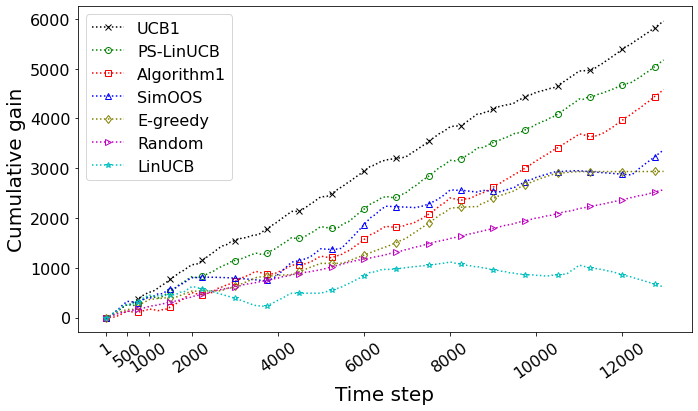

In [66]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


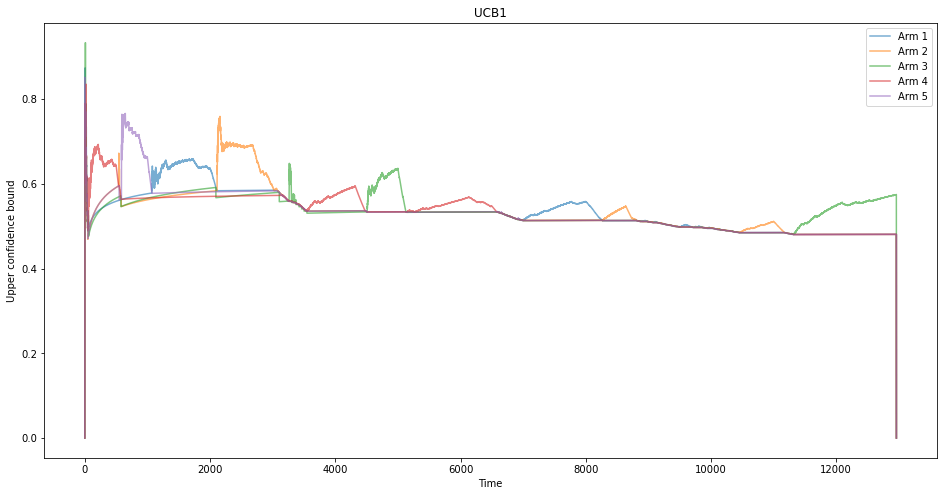

In [67]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ucb_alg.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('UCB1');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

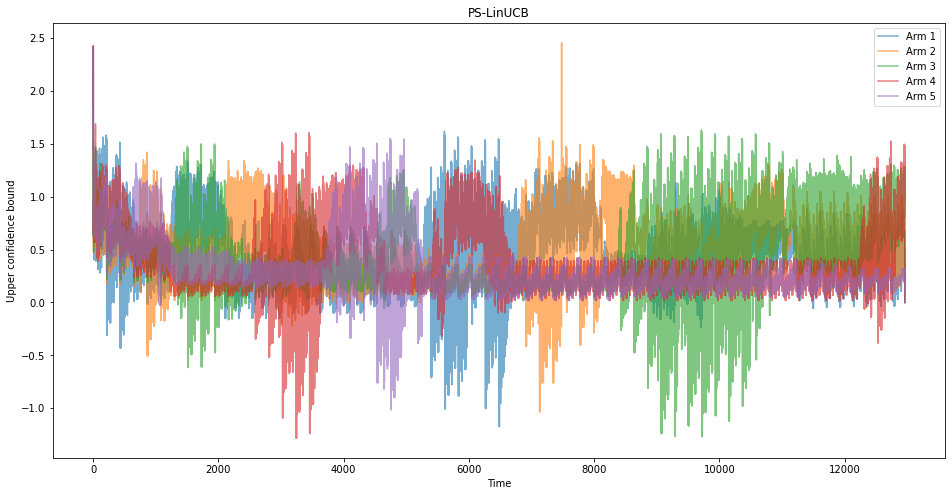

In [68]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

In [69]:
df = pd.DataFrame(
    list(
        zip(
            p_alg1.selected_action_SimOOS,
            p_alg1.collected_rewards_SimOOS, 
            p_alg1.rewards,
            p_alg1.ucbs,
            p_alg1.confidences,
            p_alg1.nus,
        )
    ),
    columns=['action', 'reward', 'r_hat', 'ucb', 'conf', 'nu']
)


In [70]:
import qgrid

widget = qgrid.show_grid(df)
widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

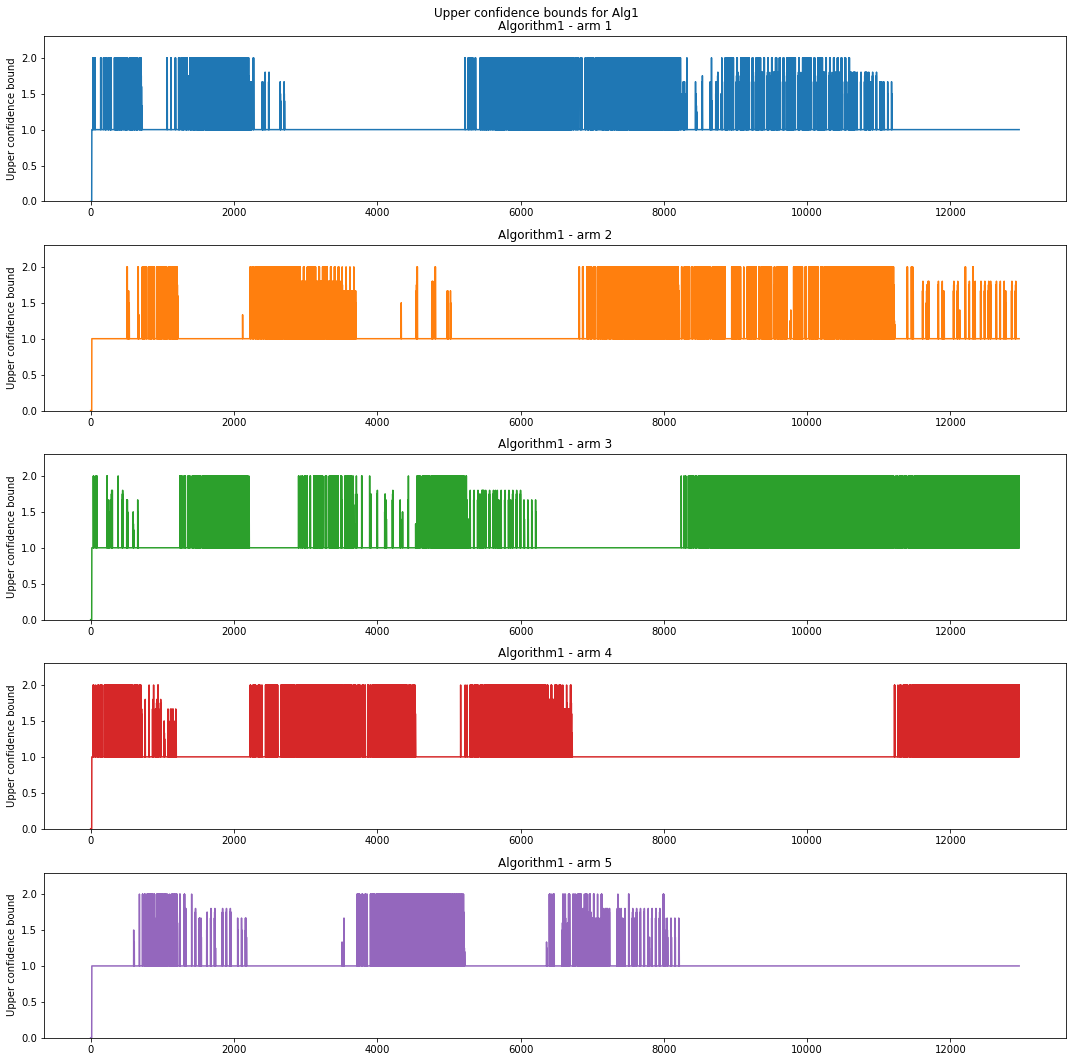

In [71]:
fig, ax = plt.subplots(5,1, figsize=(15, 15))
fig.suptitle('Upper confidence bounds for Alg1')
for i in range(5):
    ax[i].plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
    ax[i].set_title(f"Algorithm1 - arm {i+1}");
    ax[i].set_ylabel('Upper confidence bound');
    ax[i].set_ylim([0.0, 2.3])

plt.tight_layout();

In [72]:
list(p_alg1.selected_context_SimOOS)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 1.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 1.]),
 array([0., 1., 0., 0.]),
 array([0., 1., 0., 1.]),
 array([0., 1., 1., 0.]),
 array([0., 1., 1., 1.]),
 array([1., 0., 0., 0.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 1., 0.]),
 array([1., 0., 1., 1.]),
 array([1., 1., 0., 0.]),
 array([1., 1., 0., 1.]),
 array([1., 1., 1., 0.]),
 array([1., 1., 1., 1.]),
 array([0., 1., 1., 1.]),
 array([0., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 

In [73]:
list(p_alg1.costs)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([-0.96473299, -0.92396514, -0.93398424, -0.93172654]),
 array([-0.96473299, -0.8807941 , -0.8909981 , -0.88869138]),
 array([-0.96473299, -0.83170849, -0.84205465, -0.83968311]),
 array([-0.92172658, -0.78941524, -0.79981139, -0.79734993]),
 array([-0.87262498, -0.75255549, -0.76292481, -0.760512  ]),
 array([-0.83030088, -0.72009862, -0.73045816, -0.72801605]),
 array([-0.79352492, -0.69110065, -0.70154148, -0.69903848]),
 array([-0.76094685, -0.66505692, -0.67548985, -0.67301714]),
 array([-0.73199165, -0.64152835, -0.65206853, -0.64955957]),
 array([-0.70604225, -0.62